## 1. Importación de Librerías <a id='1-importacion'></a>

In [1]:
# Librerías estándar
import os
import time
import pickle

# Procesamiento de datos
import numpy as np
import pandas as pd

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, AdamW

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.9.0+cu128
CUDA available: True


## 2. Carga y Exploración de Datos <a id='2-datos'></a>

In [2]:
# Cargar dataset
path_db = "./ECG_DATASET/dataset_ekg.pkl"

with open(path_db, "rb") as f:
    dataset = pickle.load(f)

print("Clases disponibles:", list(dataset.keys()))
print("\nForma de cada clase:")
for key, value in dataset.items():
    print(f"  {key:15s}: {value.shape}")

Clases disponibles: ['NSR', 'VT', 'IVR', 'VFL', 'Fusion', 'LBBBB', 'RBBBB', 'SDHB', 'PR', 'APB', 'AFL', 'AFIB', 'SVTA', 'WPW', 'PVC', 'Bigeminy', 'Trigeminy']

Forma de cada clase:
  NSR            : (283, 3600)
  VT             : (10, 3600)
  IVR            : (10, 3600)
  VFL            : (10, 3600)
  Fusion         : (11, 3600)
  LBBBB          : (103, 3600)
  RBBBB          : (62, 3600)
  SDHB           : (10, 3600)
  PR             : (45, 3600)
  APB            : (66, 3600)
  AFL            : (20, 3600)
  AFIB           : (135, 3600)
  SVTA           : (13, 3600)
  WPW            : (21, 3600)
  PVC            : (133, 3600)
  Bigeminy       : (55, 3600)
  Trigeminy      : (13, 3600)


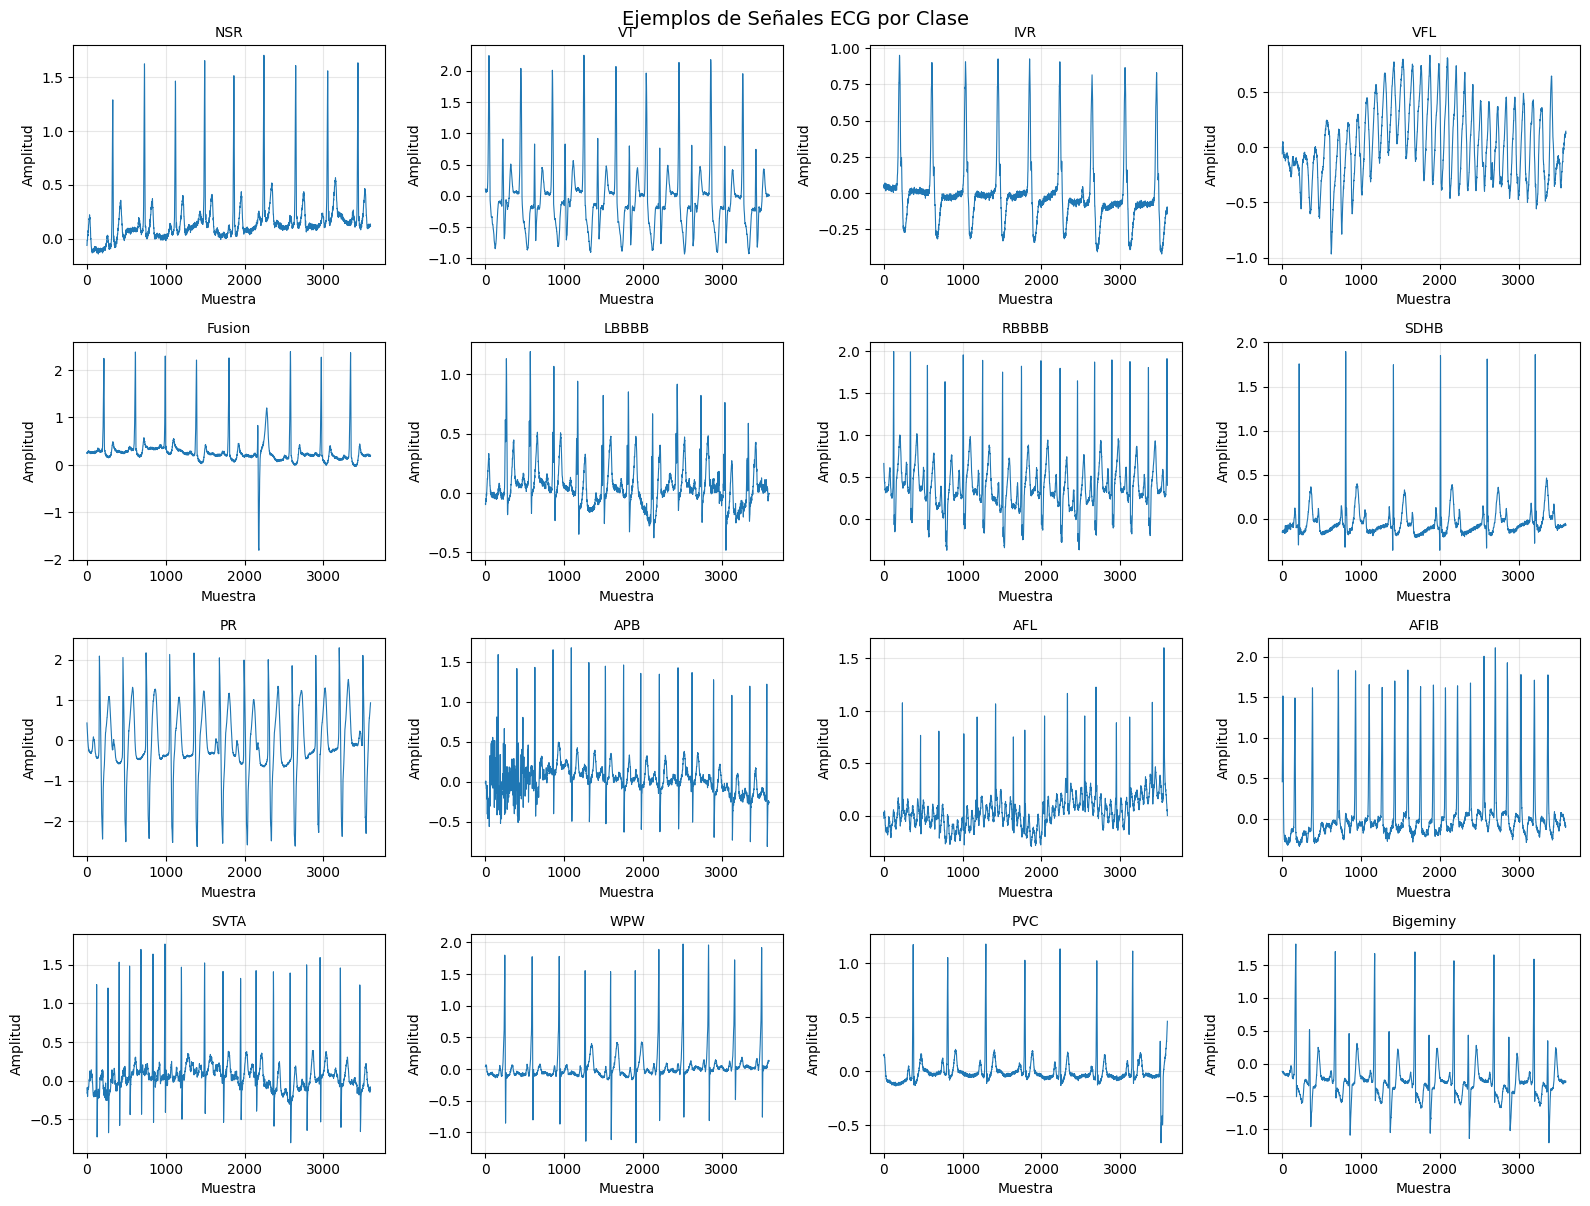

In [3]:
# Visualizar señales de ejemplo
class_names = list(dataset.keys())

fig, axes = plt.subplots(4, 4, figsize=(16, 12))
axes = axes.flatten()

for idx, class_name in enumerate(class_names[:16]):
    signal = dataset[class_name][0]
    axes[idx].plot(signal, linewidth=0.8)
    axes[idx].set_title(f"{class_name}", fontsize=10)
    axes[idx].set_xlabel("Muestra")
    axes[idx].set_ylabel("Amplitud")
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.suptitle("Ejemplos de Señales ECG por Clase", fontsize=14, y=1.001)
plt.show()

## 3. Preparación del Dataset <a id='3-dataset'></a>

In [4]:
class ECGDataset(Dataset):
    """Dataset personalizado para señales ECG"""
    
    def __init__(self, data_dict, class_to_idx, normalize=True):
        self.signals = []
        self.labels = []
        
        for class_name, signals in data_dict.items():
            class_idx = class_to_idx[class_name]
            for signal in signals:
                self.signals.append(signal)
                self.labels.append(class_idx)
        
        self.signals = np.array(self.signals, dtype=np.float32)
        self.labels = np.array(self.labels, dtype=np.int64)
        
        if normalize:
            for i in range(len(self.signals)):
                min_val = self.signals[i].min()
                max_val = self.signals[i].max()
                if max_val > min_val:
                    self.signals[i] = 2 * (self.signals[i] - min_val) / (max_val - min_val) - 1
        
        print(f"Dataset: {len(self.signals)} señales, {len(np.unique(self.labels))} clases")
    
    def __len__(self):
        return len(self.signals)
    
    def __getitem__(self, idx):
        signal = torch.FloatTensor(self.signals[idx]).unsqueeze(0)
        label = torch.LongTensor([self.labels[idx]])
        return signal, label

# Crear dataset
class_to_idx = {name: idx for idx, name in enumerate(class_names)}
idx_to_class = {idx: name for name, idx in class_to_idx.items()}

ecg_dataset = ECGDataset(dataset, class_to_idx, normalize=True)

# DataLoader
batch_size = 64
dataloader = DataLoader(ecg_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

print(f"Batch size: {batch_size}")
print(f"Número de batches: {len(dataloader)}")

Dataset: 1000 señales, 17 clases
Batch size: 64
Número de batches: 15


## 4. Arquitectura del Modelo <a id='4-arquitectura'></a>

### 4.1 Generador Mejorado (Conv + LSTM)

In [5]:
class ImprovedGenerator(nn.Module):
    """Generador mejorado: ConvTranspose + LSTM + Residual"""
    
    def __init__(self, latent_dim, num_classes, seq_length, embedding_dim=50):
        super().__init__()
        self.latent_dim = latent_dim
        self.seq_length = seq_length
        
        # Embedding de clase
        self.label_embedding = nn.Embedding(num_classes, embedding_dim)
        input_dim = latent_dim + embedding_dim
        
        # Proyección inicial
        self.fc_project = nn.Sequential(
            nn.Linear(input_dim, 256 * 14),
            nn.LeakyReLU(0.2)
        )
        
        # ConvTranspose1D progresivas
        self.deconv1 = nn.ConvTranspose1d(256, 128, kernel_size=25, stride=4, padding=11)
        self.deconv2 = nn.ConvTranspose1d(128, 64, kernel_size=25, stride=4, padding=11)
        self.deconv3 = nn.ConvTranspose1d(64, 32, kernel_size=25, stride=4, padding=11)
        self.deconv4 = nn.ConvTranspose1d(32, 16, kernel_size=25, stride=4, padding=11)
        
        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(32)
        self.bn4 = nn.BatchNorm1d(16)
        
        # LSTM para coherencia temporal
        self.lstm = nn.LSTM(16, 32, num_layers=2, batch_first=True, bidirectional=True)
        
        # Capas finales con residual
        self.conv_res1 = nn.Conv1d(64, 32, kernel_size=1)
        self.conv_res2 = nn.Conv1d(32, 16, kernel_size=1)
        self.conv_out = nn.Conv1d(16, 1, kernel_size=1)
        
    def forward(self, noise, labels):
        batch_size = noise.size(0)
        
        # Embedding + concatenar
        label_emb = self.label_embedding(labels.squeeze(1))
        x = torch.cat([noise, label_emb], dim=1)
        
        # Proyección
        x = self.fc_project(x).view(batch_size, 256, 14)
        
        # Deconvoluciones
        x = F.leaky_relu(self.bn1(self.deconv1(x)), 0.2)
        x = F.leaky_relu(self.bn2(self.deconv2(x)), 0.2)
        x = F.leaky_relu(self.bn3(self.deconv3(x)), 0.2)
        x = F.leaky_relu(self.bn4(self.deconv4(x)), 0.2)
        
        # LSTM
        x_temp = x.transpose(1, 2)
        x_temp, _ = self.lstm(x_temp)
        x_lstm = x_temp.transpose(1, 2)
        
        # Residual
        x_res = F.leaky_relu(self.conv_res1(x_lstm), 0.2)
        x_res = self.conv_res2(x_res)
        x = x + x_res[:, :, :x.size(2)]
        x = F.leaky_relu(x, 0.2)
        x = torch.tanh(self.conv_out(x))
        
        # Ajustar a longitud exacta
        x = F.interpolate(x, size=self.seq_length, mode='linear', align_corners=False)
        
        return x

print("✓ Generador mejorado definido")

✓ Generador mejorado definido


### 4.2 Discriminador Mejorado (Conv + LSTM)

In [6]:
class ImprovedDiscriminator(nn.Module):
    """Discriminador mejorado: Conv1D + Instance Norm + LSTM"""
    
    def __init__(self, num_classes, seq_length, embedding_dim=50):
        super().__init__()
        
        # Embedding de clase
        self.label_embedding = nn.Embedding(num_classes, embedding_dim)
        self.label_proj = nn.Linear(embedding_dim, seq_length)
        
        # Convoluciones
        self.conv1 = nn.Conv1d(2, 32, kernel_size=25, stride=4, padding=12)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=25, stride=4, padding=12)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=25, stride=4, padding=12)
        self.conv4 = nn.Conv1d(128, 256, kernel_size=25, stride=4, padding=12)
        
        # Instance Norm
        self.in1 = nn.InstanceNorm1d(32)
        self.in2 = nn.InstanceNorm1d(64)
        self.in3 = nn.InstanceNorm1d(128)
        self.in4 = nn.InstanceNorm1d(256)
        
        # LSTM bidireccional
        self.lstm = nn.LSTM(256, 128, num_layers=2, batch_first=True, 
                           bidirectional=True, dropout=0.3)
        
        # Clasificación
        self.fc = nn.Sequential(
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
        
    def forward(self, signal, labels):
        # Embedding + proyección
        label_emb = self.label_embedding(labels.squeeze(1))
        label_proj = self.label_proj(label_emb).unsqueeze(1)
        
        # Concatenar
        x = torch.cat([signal, label_proj], dim=1)
        
        # Convoluciones
        x = F.leaky_relu(self.in1(self.conv1(x)), 0.2)
        x = F.leaky_relu(self.in2(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.in3(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.in4(self.conv4(x)), 0.2)
        
        # LSTM
        x = x.transpose(1, 2)
        lstm_out, (h_n, _) = self.lstm(x)
        last_hidden = torch.cat([h_n[-2], h_n[-1]], dim=1)
        
        # Clasificación
        validity = self.fc(last_hidden)
        
        return validity

print("✓ Discriminador mejorado definido")

✓ Discriminador mejorado definido


## 5. Configuración de Entrenamiento <a id='5-configuracion'></a>

In [7]:
# Dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositivo: {device}")

# Hiperparámetros
latent_dim = 100
num_classes = len(class_names)
seq_length = 3600
embedding_dim = 50

lr_g = 0.0001
lr_d = 0.0001
num_epochs = 2000
sample_interval = 100

print(f"\nHiperparámetros:")
print(f"  Latent dim: {latent_dim}")
print(f"  Clases: {num_classes}")
print(f"  Seq length: {seq_length}")
print(f"  LR G/D: {lr_g} / {lr_d}")
print(f"  Épocas: {num_epochs}")

Dispositivo: cuda

Hiperparámetros:
  Latent dim: 100
  Clases: 17
  Seq length: 3600
  LR G/D: 0.0001 / 0.0001
  Épocas: 2000


In [8]:
# Crear modelos
generator = ImprovedGenerator(
    latent_dim=latent_dim,
    num_classes=num_classes,
    seq_length=seq_length,
    embedding_dim=embedding_dim
).to(device)

discriminator = ImprovedDiscriminator(
    num_classes=num_classes,
    seq_length=seq_length,
    embedding_dim=embedding_dim
).to(device)

print(f"Generador: {sum(p.numel() for p in generator.parameters()):,} parámetros")
print(f"Discriminador: {sum(p.numel() for p in discriminator.parameters()):,} parámetros")

# Optimizadores
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr_g, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))

# Schedulers
scheduler_G = torch.optim.lr_scheduler.StepLR(optimizer_G, step_size=500, gamma=0.95)
scheduler_D = torch.optim.lr_scheduler.StepLR(optimizer_D, step_size=500, gamma=0.95)

# Loss
adversarial_loss = nn.BCELoss()

print("\n✓ Modelos y optimizadores inicializados")

Generador: 1,671,267 parámetros
Discriminador: 2,085,283 parámetros

✓ Modelos y optimizadores inicializados


### 5.1 Función de Entrenamiento

In [9]:
def train_epoch(generator, discriminator, dataloader, optimizer_G, optimizer_D, 
                adversarial_loss, device):
    """Entrenamiento mejorado con múltiples losses"""
    generator.train()
    discriminator.train()
    
    epoch_g_loss = 0.0
    epoch_d_loss = 0.0
    epoch_d_real_acc = 0.0
    epoch_d_fake_acc = 0.0
    
    # Label smoothing
    real_label = 0.9
    fake_label = 0.1
    
    for i, (real_signals, labels) in enumerate(dataloader):
        batch_size = real_signals.size(0)
        real_signals = real_signals.to(device)
        labels = labels.to(device)
        
        valid = torch.full((batch_size, 1), real_label, device=device)
        fake_labels_d = torch.full((batch_size, 1), fake_label, device=device)
        
        # Entrenar Discriminador
        optimizer_D.zero_grad()
        
        real_pred = discriminator(real_signals, labels)
        d_real_loss = adversarial_loss(real_pred, valid)
        
        z = torch.randn(batch_size, latent_dim, device=device)
        gen_labels = torch.randint(0, num_classes, (batch_size, 1), device=device)
        gen_signals = generator(z, gen_labels)
        fake_pred = discriminator(gen_signals.detach(), gen_labels)
        d_fake_loss = adversarial_loss(fake_pred, fake_labels_d)
        
        d_loss = (d_real_loss + d_fake_loss) / 2
        d_loss.backward()
        torch.nn.utils.clip_grad_norm_(discriminator.parameters(), max_norm=1.0)
        optimizer_D.step()
        
        # Entrenar Generador (2 veces)
        for _ in range(2):
            optimizer_G.zero_grad()
            
            z = torch.randn(batch_size, latent_dim, device=device)
            gen_labels = torch.randint(0, num_classes, (batch_size, 1), device=device)
            gen_signals = generator(z, gen_labels)
            
            validity = discriminator(gen_signals, gen_labels)
            g_adv_loss = adversarial_loss(validity, torch.ones((batch_size, 1), device=device))
            
            # Feature matching
            real_mean = real_signals.mean(dim=2, keepdim=True)
            real_std = real_signals.std(dim=2, keepdim=True)
            fake_mean = gen_signals.mean(dim=2, keepdim=True)
            fake_std = gen_signals.std(dim=2, keepdim=True)
            feature_loss = F.mse_loss(fake_mean, real_mean) + F.mse_loss(fake_std, real_std)
            
            # Frequency loss
            real_fft = torch.fft.rfft(real_signals, dim=2)
            fake_fft = torch.fft.rfft(gen_signals, dim=2)
            freq_loss = F.l1_loss(torch.abs(fake_fft), torch.abs(real_fft))
            
            g_loss = g_adv_loss + 0.1 * feature_loss + 0.05 * freq_loss
            
            g_loss.backward()
            torch.nn.utils.clip_grad_norm_(generator.parameters(), max_norm=1.0)
            optimizer_G.step()
        
        # Métricas
        epoch_g_loss += g_loss.item()
        epoch_d_loss += d_loss.item()
        epoch_d_real_acc += (real_pred > 0.5).float().mean().item()
        epoch_d_fake_acc += (fake_pred < 0.5).float().mean().item()
    
    num_batches = len(dataloader)
    return {
        'g_loss': epoch_g_loss / num_batches,
        'd_loss': epoch_d_loss / num_batches,
        'd_real_acc': epoch_d_real_acc / num_batches,
        'd_fake_acc': epoch_d_fake_acc / num_batches
    }

print("✓ Función de entrenamiento definida")

✓ Función de entrenamiento definida


### 5.2 Función de Visualización

In [10]:
def generate_and_plot_signals(generator, num_classes, idx_to_class, latent_dim, 
                              seq_length, device, epoch, save_dir='generated_samples'):
    """Genera y visualiza señales sintéticas"""
    generator.eval()
    os.makedirs(save_dir, exist_ok=True)
    
    fig, axes = plt.subplots(4, 5, figsize=(20, 12))
    axes = axes.flatten()
    
    with torch.no_grad():
        for class_idx in range(min(num_classes, 20)):
            z = torch.randn(1, latent_dim, device=device)
            label = torch.LongTensor([[class_idx]]).to(device)
            gen_signal = generator(z, label).cpu().numpy().squeeze()
            
            axes[class_idx].plot(gen_signal, linewidth=0.8)
            axes[class_idx].set_title(f"{idx_to_class[class_idx]}", fontsize=10)
            axes[class_idx].set_xlabel("Muestra")
            axes[class_idx].set_ylabel("Amplitud")
            axes[class_idx].grid(alpha=0.3)
            axes[class_idx].set_ylim(-1.5, 1.5)
    
    for idx in range(num_classes, 20):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.suptitle(f"Señales Generadas - Epoch {epoch}", fontsize=14, y=1.001)
    
    save_path = os.path.join(save_dir, f'epoch_{epoch:04d}.png')
    plt.savefig(save_path, dpi=100, bbox_inches='tight')
    plt.close()
    
    print(f"  → Muestras guardadas en {save_path}")
    generator.train()

print("✓ Función de visualización definida")

✓ Función de visualización definida


## 6. Entrenamiento <a id='6-entrenamiento'></a>

In [11]:
# Historial
history = {
    'g_loss': [],
    'd_loss': [],
    'd_real_acc': [],
    'd_fake_acc': []
}

print("="*80)
print("ENTRENAMIENTO CGAN-LSTM")
print("="*80)

start_time = time.time()

for epoch in range(num_epochs):
    epoch_start = time.time()
    
    metrics = train_epoch(
        generator, discriminator, dataloader,
        optimizer_G, optimizer_D, adversarial_loss, device
    )
    
    # Guardar métricas
    for key in history.keys():
        history[key].append(metrics[key])
    
    # Update LR
    scheduler_G.step()
    scheduler_D.step()
    
    epoch_time = time.time() - epoch_start
    
    # Imprimir
    if (epoch + 1) % 50 == 0 or epoch == 0:
        lr_g = optimizer_G.param_groups[0]['lr']
        print(f"Epoch [{epoch+1:4d}/{num_epochs}] | "
              f"G: {metrics['g_loss']:.4f} | "
              f"D: {metrics['d_loss']:.4f} | "
              f"D_real: {metrics['d_real_acc']:.3f} | "
              f"D_fake: {metrics['d_fake_acc']:.3f} | "
              f"LR: {lr_g:.6f} | "
              f"{epoch_time:.2f}s")
    
    # Visualizar
    if (epoch + 1) % sample_interval == 0:
        generate_and_plot_signals(
            generator, num_classes, idx_to_class, latent_dim,
            seq_length, device, epoch + 1
        )

total_time = time.time() - start_time
print("\n" + "="*80)
print(f"Entrenamiento completado en {total_time/60:.2f} minutos")
print("="*80)

ENTRENAMIENTO CGAN-LSTM
Epoch [   1/2000] | G: 1.0726 | D: 0.6692 | D_real: 0.868 | D_fake: 0.496 | LR: 0.000100 | 1.33s
Epoch [  50/2000] | G: 2.5542 | D: 0.3802 | D_real: 0.973 | D_fake: 0.942 | LR: 0.000100 | 1.03s
Epoch [ 100/2000] | G: 2.5210 | D: 0.3467 | D_real: 0.997 | D_fake: 0.976 | LR: 0.000100 | 1.04s
  → Muestras guardadas en generated_samples/epoch_0100.png
Epoch [ 150/2000] | G: 2.5094 | D: 0.3393 | D_real: 0.997 | D_fake: 0.979 | LR: 0.000100 | 1.03s
Epoch [ 200/2000] | G: 2.5432 | D: 0.3263 | D_real: 1.000 | D_fake: 1.000 | LR: 0.000100 | 1.04s
  → Muestras guardadas en generated_samples/epoch_0200.png
Epoch [ 250/2000] | G: 2.4754 | D: 0.3449 | D_real: 0.995 | D_fake: 0.976 | LR: 0.000100 | 1.04s
Epoch [ 300/2000] | G: 2.4563 | D: 0.3416 | D_real: 0.999 | D_fake: 0.983 | LR: 0.000100 | 1.04s
  → Muestras guardadas en generated_samples/epoch_0300.png
Epoch [ 350/2000] | G: 2.4974 | D: 0.3262 | D_real: 1.000 | D_fake: 1.000 | LR: 0.000100 | 1.04s
Epoch [ 400/2000] | G: 

## 7. Evaluación y Visualización <a id='7-evaluacion'></a>

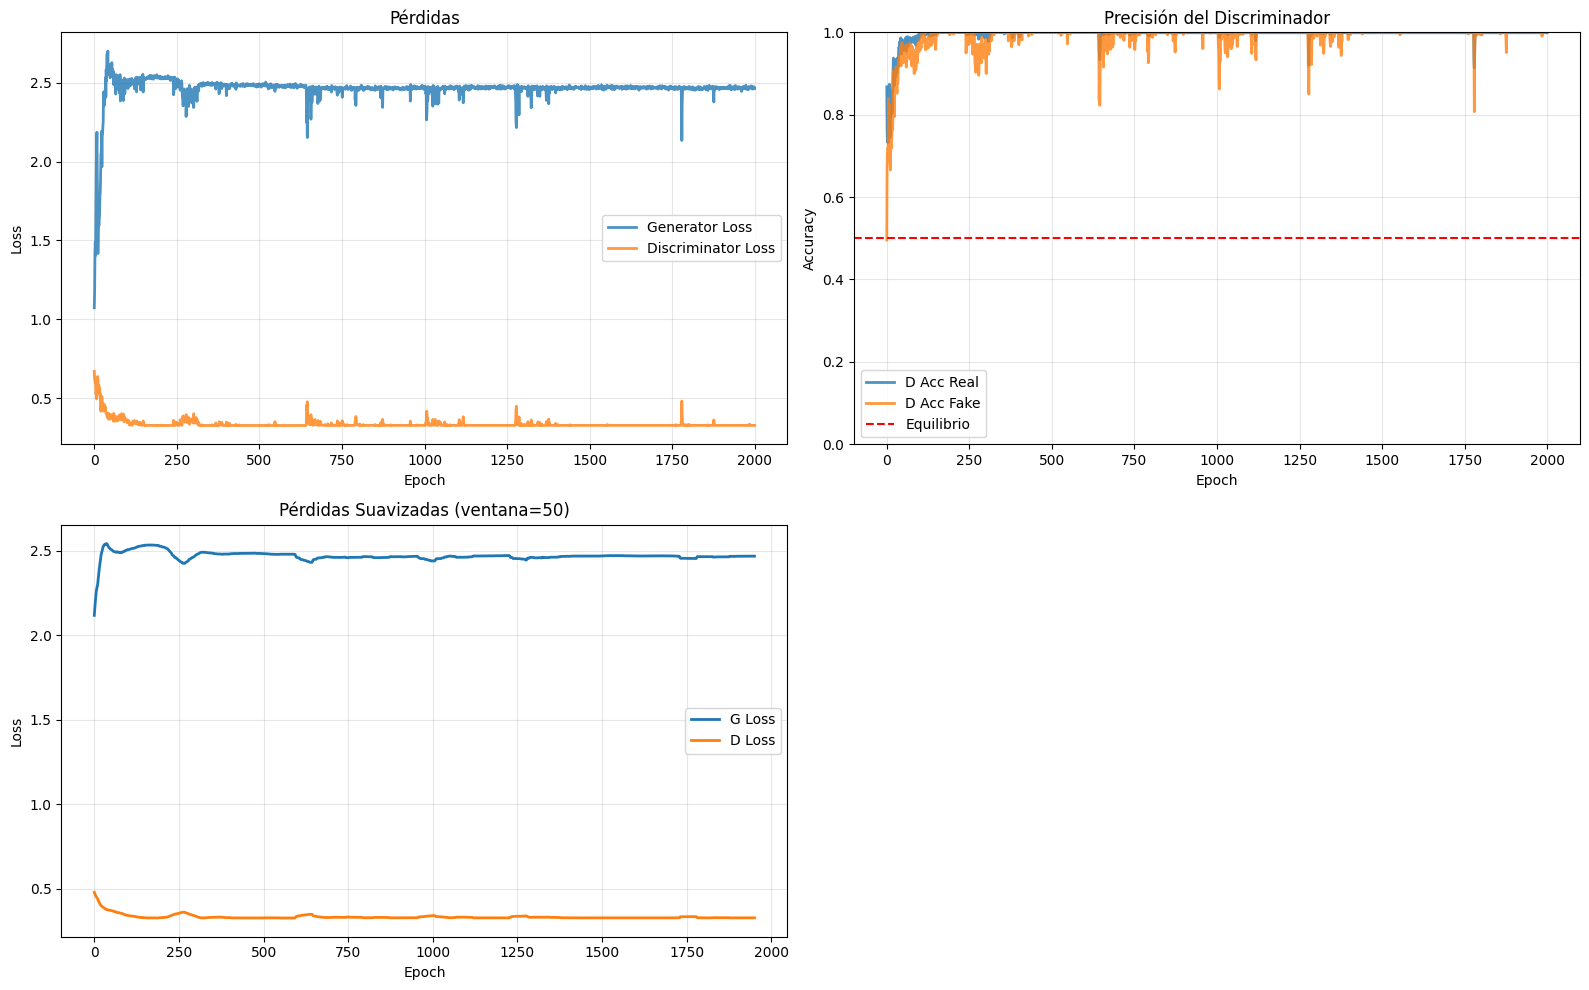

✓ Métricas visualizadas


In [12]:
# Visualizar métricas
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Pérdidas
axes[0, 0].plot(history['g_loss'], label='Generator Loss', linewidth=2, alpha=0.8)
axes[0, 0].plot(history['d_loss'], label='Discriminator Loss', linewidth=2, alpha=0.8)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Pérdidas')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Precisiones
axes[0, 1].plot(history['d_real_acc'], label='D Acc Real', linewidth=2, alpha=0.8)
axes[0, 1].plot(history['d_fake_acc'], label='D Acc Fake', linewidth=2, alpha=0.8)
axes[0, 1].axhline(y=0.5, color='r', linestyle='--', label='Equilibrio')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Precisión del Discriminador')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)
axes[0, 1].set_ylim(0, 1)

# Loss suavizado
window = 50
if len(history['g_loss']) >= window:
    g_smooth = np.convolve(history['g_loss'], np.ones(window)/window, mode='valid')
    d_smooth = np.convolve(history['d_loss'], np.ones(window)/window, mode='valid')
    
    axes[1, 0].plot(g_smooth, label='G Loss', linewidth=2)
    axes[1, 0].plot(d_smooth, label='D Loss', linewidth=2)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].set_title(f'Pérdidas Suavizadas (ventana={window})')
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3)

axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig('training_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Métricas visualizadas")

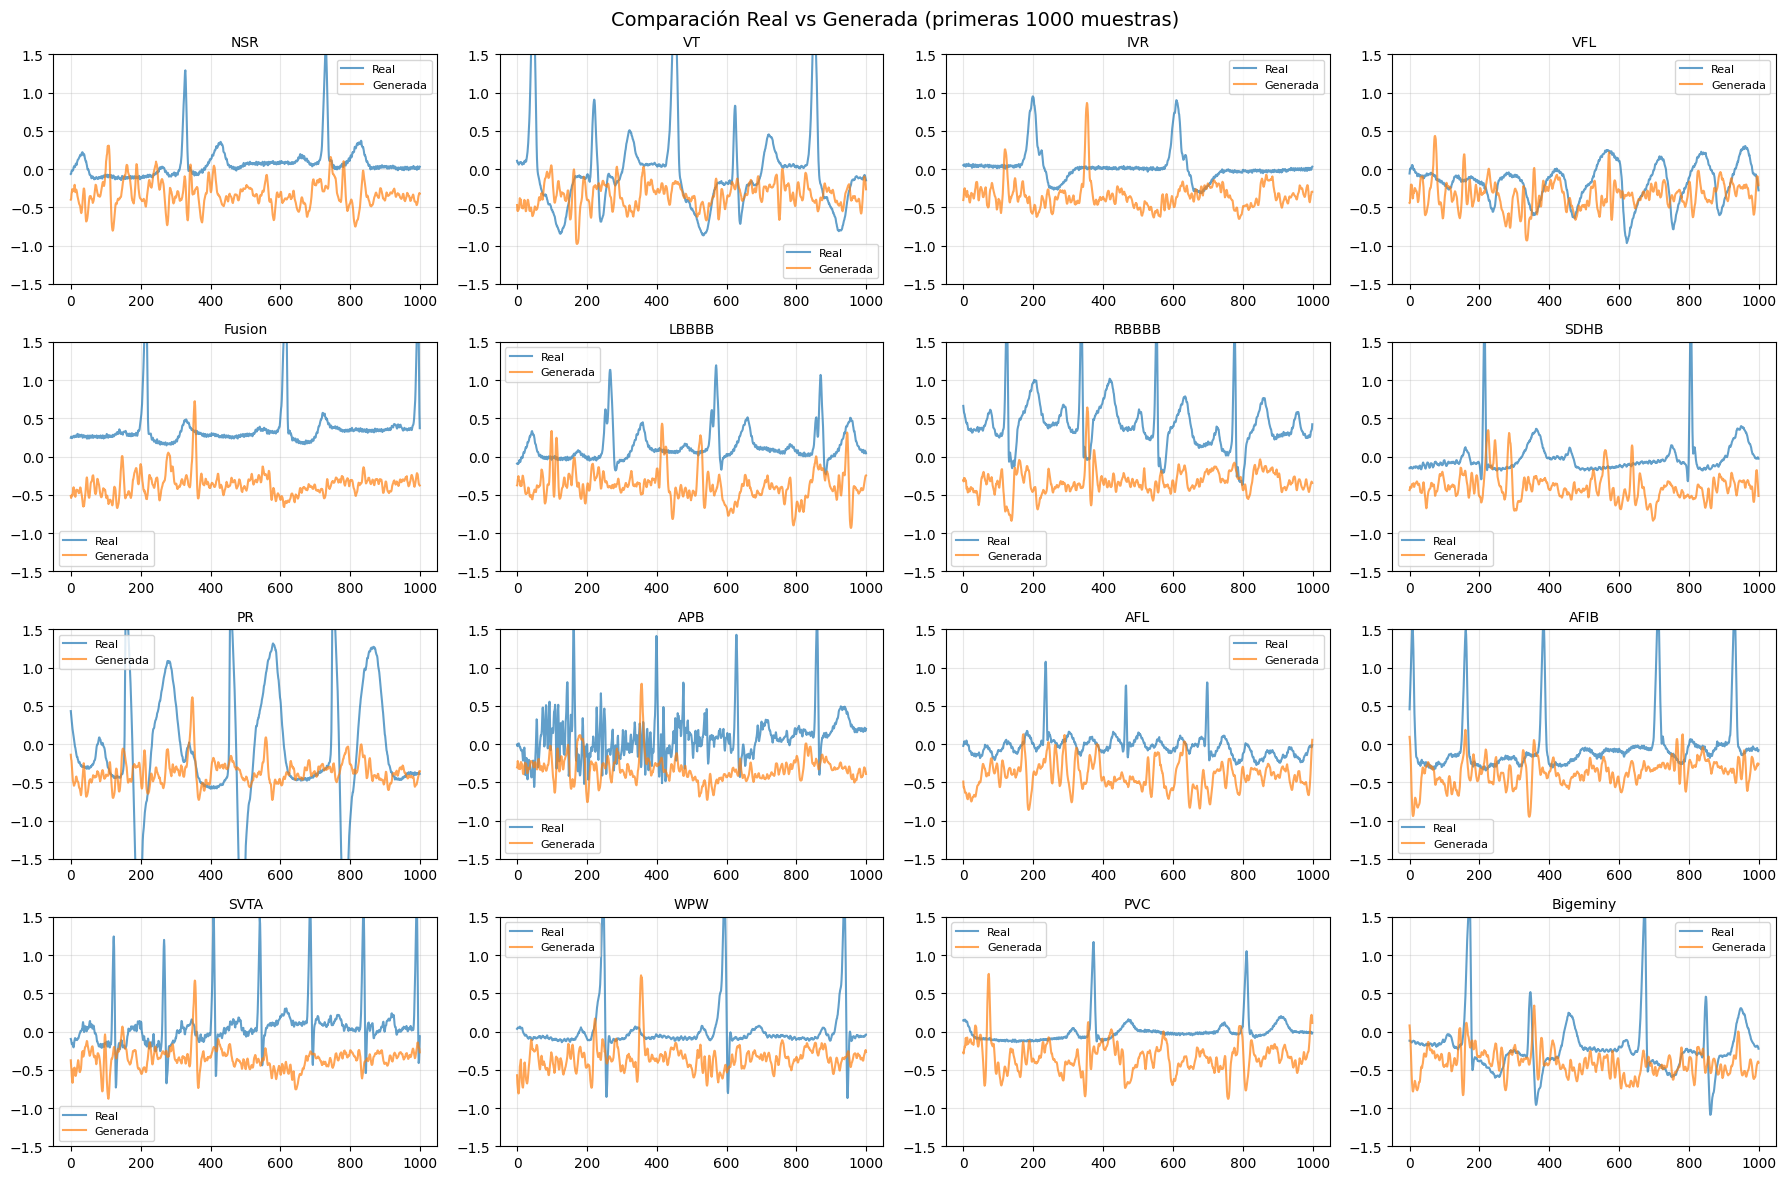

✓ Comparación completada


In [13]:
# Comparar Real vs Generado
generator.eval()

fig, axes = plt.subplots(4, 4, figsize=(18, 12))
axes = axes.flatten()

with torch.no_grad():
    for idx, class_name in enumerate(class_names[:16]):
        class_idx = class_to_idx[class_name]
        real_signal = dataset[class_name][0]
        
        z = torch.randn(1, latent_dim, device=device)
        label = torch.LongTensor([[class_idx]]).to(device)
        gen_signal = generator(z, label).cpu().numpy().squeeze()
        
        axes[idx].plot(real_signal[:1000], label='Real', linewidth=1.5, alpha=0.7)
        axes[idx].plot(gen_signal[:1000], label='Generada', linewidth=1.5, alpha=0.7)
        axes[idx].set_title(f"{class_name}", fontsize=10)
        axes[idx].set_ylim(-1.5, 1.5)
        axes[idx].grid(alpha=0.3)
        axes[idx].legend(fontsize=8)

plt.suptitle("Comparación Real vs Generada (primeras 1000 muestras)", fontsize=14)
plt.tight_layout()
plt.savefig('comparison_real_vs_generated.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Comparación completada")

## 8. Guardar y Cargar Modelos <a id='8-guardar'></a>

In [14]:
# Guardar modelos
os.makedirs('models', exist_ok=True)

torch.save({
    'epoch': num_epochs,
    'model_state_dict': generator.state_dict(),
    'optimizer_state_dict': optimizer_G.state_dict(),
    'history': history,
    'config': {
        'latent_dim': latent_dim,
        'num_classes': num_classes,
        'seq_length': seq_length,
        'embedding_dim': embedding_dim
    }
}, 'models/generator_cgan_lstm.pth')

torch.save({
    'epoch': num_epochs,
    'model_state_dict': discriminator.state_dict(),
    'optimizer_state_dict': optimizer_D.state_dict(),
}, 'models/discriminator_cgan_lstm.pth')

print("✓ Modelos guardados")

✓ Modelos guardados


In [15]:
# Función para cargar
def load_generator(checkpoint_path, device='cpu'):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    config = checkpoint['config']
    
    generator = ImprovedGenerator(
        latent_dim=config['latent_dim'],
        num_classes=config['num_classes'],
        seq_length=config['seq_length'],
        embedding_dim=config['embedding_dim']
    ).to(device)
    
    generator.load_state_dict(checkpoint['model_state_dict'])
    generator.eval()
    
    print(f"Generador cargado (epoch {checkpoint['epoch']})")
    return generator, config

# Ejemplo de uso
def generate_ecg_for_class(generator, class_name, class_to_idx, latent_dim, 
                           num_samples=5, device='cpu'):
    generator.eval()
    class_idx = class_to_idx[class_name]
    
    signals = []
    with torch.no_grad():
        for _ in range(num_samples):
            z = torch.randn(1, latent_dim, device=device)
            label = torch.LongTensor([[class_idx]]).to(device)
            signal = generator(z, label).cpu().numpy().squeeze()
            signals.append(signal)
    
    return np.array(signals)

print("✓ Funciones de carga definidas")

✓ Funciones de carga definidas


---

## 📊 Resumen

### Arquitectura Mejorada:
- **Generador**: ConvTranspose1D + LSTM + Residual connections
- **Discriminador**: Conv1D + Instance Norm + LSTM bidireccional

### Mejoras Clave:
1. ✅ ConvTranspose1D para generación progresiva
2. ✅ Instance Normalization (más estable que BatchNorm)
3. ✅ Feature matching loss
4. ✅ Frequency domain loss
5. ✅ Label smoothing
6. ✅ Gradient clipping
7. ✅ Learning rate scheduling

### Uso:
```python
# Generar señales
signals = generate_ecg_for_class(generator, 'NSR', class_to_idx, latent_dim, num_samples=10)

# Cargar modelo guardado
loaded_gen, config = load_generator('models/generator_cgan_lstm.pth', device)
```